# Complete Hangman Agent: HMM + Q-Learning Implementation
**UE23CS352A Machine Learning Hackathon - Implementation 1**

---

## Implementation Overview

This notebook implements a hybrid intelligent Hangman agent combining:

### Part 1: Complete Hidden Markov Model (HMM)
- **Forward Algorithm (α)**: Compute observation likelihood P(O|λ)
- **Backward Algorithm (β)**: Compute posterior probabilities
- **Viterbi Algorithm (δ)**: Find most likely state sequence
- **Emission Matrix (B)**: P(letter | position)
- **Transition Matrix (A)**: P(letter_j | letter_i)

### Part 2: Q-Learning Agent
- Tabular Q-Learning for strategic decision making
- Epsilon-greedy exploration strategy
- Hybrid action selection combining HMM guidance and Q-values

---

##  Theory Background

### HMM Components
- **States (Q)**: Word positions {0, 1, ..., length-1}
- **Observations (O)**: Letters {a, b, ..., z}
- **Initial Distribution (π)**: P(starting in state i)
- **Transition Matrix (A)**: P(next_letter | current_letter)
- **Emission Matrix (B)**: P(letter | position)

### Three Fundamental HMM Problems
1. **Likelihood Problem**: Given model λ=(A,B,π) and observations O, compute P(O|λ)
   - Solution: **Forward Algorithm**
2. **Decoding Problem**: Given λ and O, find best state sequence Q*
   - Solution: **Viterbi Algorithm**
3. **Learning Problem**: Given observations O, find λ that maximizes P(O|λ)
   - Solution: **Baum-Welch Algorithm** (we use MLE from corpus)

### Q-Learning
- **Q-value**: Q(s,a) = expected cumulative reward for action a in state s
- **Update Rule**: Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
- **Policy**: π(s) = argmax_a Q(s,a)

## Section 1: Setup and Dependencies

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import random
import string
from typing import List, Dict, Tuple, Set
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✓ All dependencies loaded")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

✓ All dependencies loaded
✓ NumPy version: 2.0.2
✓ Pandas version: 2.2.2


## Section 2: Data Loading and Analysis

In [2]:
# Load training corpus
with open('corpus.txt', 'r') as f:
    corpus = [word.strip().lower() for word in f.readlines() if word.strip()]

# Load test set
with open('test.txt', 'r') as f:
    test_words = [word.strip().lower() for word in f.readlines() if word.strip()]

print(f"📊 Corpus size: {len(corpus):,} words")
print(f"📊 Test set size: {len(test_words):,} words")
print(f"\n📝 Sample corpus words: {corpus[:10]}")
print(f"📝 Sample test words: {test_words[:5]}")

# Analyze word length distribution
corpus_lengths = [len(w) for w in corpus]
test_lengths = [len(w) for w in test_words]

print(f"\n📈 Corpus length statistics:")
print(f"   Min: {min(corpus_lengths)}, Max: {max(corpus_lengths)}, Mean: {np.mean(corpus_lengths):.2f}")
print(f"\n📈 Test length statistics:")
print(f"   Min: {min(test_lengths)}, Max: {max(test_lengths)}, Mean: {np.mean(test_lengths):.2f}")

📊 Corpus size: 50,000 words
📊 Test set size: 2,000 words

📝 Sample corpus words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
📝 Sample test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify']

📈 Corpus length statistics:
   Min: 1, Max: 24, Mean: 9.50

📈 Test length statistics:
   Min: 2, Max: 22, Mean: 9.64


## Section 3: Complete Hidden Markov Model Implementation

### HMM Structure for Hangman
- **States**: Word positions (0 to length-1)
- **Observations**: Letters (a-z, plus unknown '_')
- **Training**: Separate HMM for each word length using Maximum Likelihood Estimation

### Algorithms Implemented
1. **Forward Algorithm**: Efficiently compute P(O|λ) in O(N²T) time
2. **Backward Algorithm**: Compute posterior probabilities
3. **Viterbi Algorithm**: Find optimal state sequence
4. **Letter Probability Inference**: Use HMM for next letter prediction

In [3]:
class CompleteHiddenMarkovModel:
    """
    Complete HMM with Forward, Backward, and Viterbi algorithms.

    Theory:
    - Forward: α_t(j) = P(O_1,...,O_t, q_t=j | λ)
    - Backward: β_t(i) = P(O_{t+1},...,O_T | q_t=i, λ)
    - Viterbi: δ_t(j) = max P(q_1,...,q_{t-1}, q_t=j, O_1,...,O_t | λ)
    """

    def __init__(self, max_length=30, smoothing=1e-4):
        self.max_length = max_length
        self.smoothing = smoothing
        self.alphabet = string.ascii_lowercase
        self.vocab_size = 26
        self.models = {}  # {length: {'pi', 'A', 'B'}}

    def train(self, words: List[str]):
        """Train HMM on corpus using Maximum Likelihood Estimation"""
        print("\n🔧 Training Complete HMM...")

        # Group words by length
        words_by_length = defaultdict(list)
        for word in words:
            if len(word) <= self.max_length:
                words_by_length[len(word)].append(word)

        # Train separate HMM for each length
        for length in sorted(words_by_length.keys()):
            words_of_length = words_by_length[length]
            self.models[length] = self._train_single_hmm(words_of_length, length)
            if length % 5 == 0:  # Progress indicator
                print(f"   ✓ Trained HMM for length {length} ({len(words_of_length)} words)")

        print(f"\n✅ HMM Training Complete!")
        print(f"   Trained models for {len(self.models)} different word lengths")
        print(f"   Length range: {min(self.models.keys())} to {max(self.models.keys())}")

    def _train_single_hmm(self, words: List[str], length: int) -> Dict:
        """Train HMM for specific word length using MLE"""
        n_states = length
        n_obs = self.vocab_size

        # Initialize counts
        emission_counts = defaultdict(lambda: defaultdict(int))
        position_counts = defaultdict(int)
        transition_counts = defaultdict(lambda: defaultdict(int))
        letter_counts = defaultdict(int)

        # Count statistics
        for word in words:
            # Emission counts P(letter | position)
            for pos, letter in enumerate(word):
                letter_idx = ord(letter) - ord('a')
                emission_counts[pos][letter_idx] += 1
                position_counts[pos] += 1

            # Transition counts P(letter_j | letter_i)
            for i in range(len(word) - 1):
                curr = ord(word[i]) - ord('a')
                next_l = ord(word[i+1]) - ord('a')
                transition_counts[curr][next_l] += 1
                letter_counts[curr] += 1

        # Compute emission matrix B with smoothing
        B = np.zeros((n_states, n_obs))
        for pos in range(n_states):
            total = position_counts[pos] + self.smoothing * n_obs
            for letter_idx in range(n_obs):
                count = emission_counts[pos].get(letter_idx, 0)
                B[pos, letter_idx] = (count + self.smoothing) / total

        # Compute transition matrix A with smoothing
        A = np.zeros((n_obs, n_obs))
        for i in range(n_obs):
            total = letter_counts[i] + self.smoothing * n_obs
            for j in range(n_obs):
                count = transition_counts[i].get(j, 0)
                A[i, j] = (count + self.smoothing) / total

        # Initial distribution (uniform)
        pi = np.ones(n_states) / n_states

        return {'pi': pi, 'A': A, 'B': B, 'length': length}

    def forward(self, observations: List[int], model: Dict) -> Tuple[np.ndarray, float]:
        """
        Forward Algorithm: α_t(i) = P(O_1,...,O_t, q_t=i | λ)

        Time Complexity: O(N²T)
        Space Complexity: O(NT)
        """
        T = len(observations)
        N = model['length']
        pi, B = model['pi'], model['B']

        alpha = np.zeros((T, N))

        # Initialization: α_1(i) = π_i * b_i(O_1)
        for i in range(N):
            if observations[0] >= 0:
                alpha[0, i] = pi[i] * B[i, observations[0]]
            else:
                alpha[0, i] = pi[i]

        # Recursion: α_t(j) = [Σ_i α_{t-1}(i)] * b_j(O_t)
        for t in range(1, T):
            for j in range(N):
                if observations[t] >= 0:
                    alpha[t, j] = np.sum(alpha[t-1, :]) * B[j, observations[t]]
                else:
                    alpha[t, j] = np.sum(alpha[t-1, :])

        # Termination: P(O|λ) = Σ_i α_T(i)
        likelihood = np.sum(alpha[T-1, :])
        return alpha, likelihood

    def backward(self, observations: List[int], model: Dict) -> np.ndarray:
        """
        Backward Algorithm: β_t(i) = P(O_{t+1},...,O_T | q_t=i, λ)
        """
        T = len(observations)
        N = model['length']
        B = model['B']

        beta = np.zeros((T, N))
        beta[T-1, :] = 1  # Initialization

        # Recursion: β_t(i) = Σ_j b_j(O_{t+1}) * β_{t+1}(j)
        for t in range(T-2, -1, -1):
            for i in range(N):
                if observations[t+1] >= 0:
                    beta[t, i] = np.sum(B[:, observations[t+1]] * beta[t+1, :])
                else:
                    beta[t, i] = np.sum(beta[t+1, :])

        return beta

    def viterbi(self, observations: List[int], model: Dict) -> Tuple[List[int], float]:
        """
        Viterbi Algorithm: Find most likely state sequence
        δ_t(j) = max P(q_1,...,q_{t-1}, q_t=j, O_1,...,O_t | λ)
        """
        T = len(observations)
        N = model['length']
        pi, B = model['pi'], model['B']

        delta = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)

        # Initialization
        for i in range(N):
            if observations[0] >= 0:
                delta[0, i] = pi[i] * B[i, observations[0]]
            else:
                delta[0, i] = pi[i]

        # Recursion
        for t in range(1, T):
            for j in range(N):
                probs = delta[t-1, :]
                psi[t, j] = np.argmax(probs)
                if observations[t] >= 0:
                    delta[t, j] = np.max(probs) * B[j, observations[t]]
                else:
                    delta[t, j] = np.max(probs)

        # Backtrack
        path = [0] * T
        path[T-1] = np.argmax(delta[T-1, :])
        for t in range(T-2, -1, -1):
            path[t] = psi[t+1, path[t+1]]

        return path, np.max(delta[T-1, :])

    def get_letter_probabilities(self, masked_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        """
        Infer letter probabilities for blanks using HMM emission probabilities
        """
        word_length = len(masked_word)

        if word_length not in self.models:
            remaining = [l for l in self.alphabet if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining}

        model = self.models[word_length]
        B = model['B']

        letter_probs = defaultdict(float)

        for pos, char in enumerate(masked_word):
            if char == '_':
                for letter in self.alphabet:
                    if letter not in guessed_letters:
                        letter_idx = ord(letter) - ord('a')
                        letter_probs[letter] += B[pos, letter_idx]

        # Normalize
        total = sum(letter_probs.values())
        if total > 0:
            return {k: v/total for k, v in letter_probs.items()}
        else:
            remaining = [l for l in self.alphabet if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining}

print("✅ CompleteHiddenMarkovModel class defined")

✅ CompleteHiddenMarkovModel class defined


## Section 4: Train HMM on Corpus

In [4]:
# Initialize and train HMM
hmm = CompleteHiddenMarkovModel(max_length=30, smoothing=1e-4)
hmm.train(corpus)

print("\n📊 HMM Model Statistics:")
print(f"   Total models trained: {len(hmm.models)}")
print(f"   Word lengths covered: {sorted(hmm.models.keys())}")


🔧 Training Complete HMM...
   ✓ Trained HMM for length 5 (2340 words)
   ✓ Trained HMM for length 10 (6465 words)
   ✓ Trained HMM for length 15 (1226 words)
   ✓ Trained HMM for length 20 (40 words)

✅ HMM Training Complete!
   Trained models for 24 different word lengths
   Length range: 1 to 24

📊 HMM Model Statistics:
   Total models trained: 24
   Word lengths covered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## Section 5: Test HMM Algorithms

Let's verify Forward, Backward, and Viterbi algorithms work correctly.

In [5]:
# Test HMM on a sample word
test_word = "apple"
test_masked = "_pp__"
test_guessed = set()

print(f"🧪 Testing HMM on word: '{test_word}'")
print(f"   Masked as: '{test_masked}'")

# Get letter probabilities
probs = hmm.get_letter_probabilities(test_masked, test_guessed)
top_letters = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\n📈 Top 5 predicted letters:")
for letter, prob in top_letters:
    print(f"   {letter}: {prob:.4f}")

# Test Forward Algorithm
if len(test_word) in hmm.models:
    model = hmm.models[len(test_word)]
    observations = [ord(c) - ord('a') for c in test_word]
    alpha, likelihood = hmm.forward(observations, model)
    print(f"\n🔍 Forward Algorithm: P('{test_word}'|λ) = {likelihood:.6e}")

    # Test Viterbi
    path, prob = hmm.viterbi(observations, model)
    print(f"🔍 Viterbi: Most likely path = {path}, prob = {prob:.6e}")

🧪 Testing HMM on word: 'apple'
   Masked as: '_pp__'

📈 Top 5 predicted letters:
   e: 0.1023
   a: 0.0853
   s: 0.0772
   t: 0.0642
   l: 0.0551

🔍 Forward Algorithm: P('apple'|λ) = 3.130268e-04
🔍 Viterbi: Most likely path = [np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(4)], prob = 1.565862e-06


## Section 6: Hangman Game Environment

In [6]:
class HangmanEnvironment:
    """Hangman game environment"""

    def __init__(self, word: str, max_wrong=6):
        self.word = word.lower()
        self.max_wrong = max_wrong
        self.reset()

    def reset(self):
        self.wrong_guesses = 0
        self.guessed_letters = set()
        self.correct_letters = set()
        self.game_over = False
        self.won = False

    def get_masked_word(self) -> str:
        return ''.join([c if c in self.correct_letters else '_' for c in self.word])

    def guess(self, letter: str) -> Tuple[float, bool, bool, str]:
        """Make a guess. Returns (reward, done, won, message)"""
        letter = letter.lower()

        # Repeated guess
        if letter in self.guessed_letters:
            return -2, self.game_over, self.won, "repeated"

        self.guessed_letters.add(letter)

        # Correct guess
        if letter in self.word:
            self.correct_letters.add(letter)
            reward = 5

            # Check win
            if set(self.correct_letters) >= set(self.word):
                self.game_over = True
                self.won = True
                return 100, True, True, "won"

            return reward, False, False, "correct"

        # Wrong guess
        else:
            self.wrong_guesses += 1
            reward = -10

            # Check loss
            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                self.won = False
                return -20, True, False, "lost"

            return reward, False, False, "wrong"

    def get_state(self) -> Dict:
        return {
            'masked_word': self.get_masked_word(),
            'guessed_letters': self.guessed_letters.copy(),
            'correct_letters': self.correct_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong - self.wrong_guesses
        }

# Test environment
env = HangmanEnvironment("test")
print(f"✅ HangmanEnvironment class defined")
print(f"🎮 Test: Word='test', Masked={env.get_masked_word()}")
reward, done, won, msg = env.guess('t')
print(f"   After guessing 't': Masked={env.get_masked_word()}, Reward={reward}")

✅ HangmanEnvironment class defined
🎮 Test: Word='test', Masked=____
   After guessing 't': Masked=t__t, Reward=5


## Section 7: Q-Learning Agent

### Q-Learning Algorithm
- **Q-Table**: Stores Q(s,a) values for state-action pairs
- **Update**: Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
- **Exploration**: Epsilon-greedy strategy
- **Hybrid**: Combines Q-values (60%) with HMM probabilities (40%)

In [7]:
class QLearningAgent:
    """Q-Learning agent with HMM guidance"""

    def __init__(self, hmm, learning_rate=0.1, discount=0.95, epsilon=1.0):
        self.hmm = hmm
        self.alpha = learning_rate
        self.gamma = discount
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.alphabet = string.ascii_lowercase

        self.q_table = {}  # {state_key: {action: q_value}}
        self.visit_counts = defaultdict(int)

    def state_key(self, masked_word: str, guessed: Set[str], lives: int) -> str:
        """Create state key for Q-table"""
        guessed_str = ''.join(sorted(guessed))
        return f"{masked_word}|{guessed_str}|{lives}"

    def get_available_actions(self, guessed: Set[str]) -> List[str]:
        """Get unguessed letters"""
        return [l for l in self.alphabet if l not in guessed]

    def choose_action(self, masked_word: str, guessed: Set[str], lives: int, training=True) -> str:
        """Select action using epsilon-greedy + HMM guidance"""
        available = self.get_available_actions(guessed)
        if not available:
            return None

        state = self.state_key(masked_word, guessed, lives)

        # Exploration
        if training and np.random.random() < self.epsilon:
            return np.random.choice(available)

        # Exploitation: Hybrid approach
        # Get Q-values
        q_values = {}
        if state in self.q_table:
            q_values = {a: self.q_table[state].get(a, 0) for a in available}
        else:
            q_values = {a: 0 for a in available}

        # Normalize Q-values
        q_vals = list(q_values.values())
        if max(q_vals) > min(q_vals):
            q_min, q_max = min(q_vals), max(q_vals)
            q_values = {a: (v - q_min)/(q_max - q_min) for a, v in q_values.items()}

        # Get HMM probabilities
        hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed)

        # Combine: 60% Q-values + 40% HMM
        scores = {}
        for action in available:
            scores[action] = 0.6 * q_values.get(action, 0) + 0.4 * hmm_probs.get(action, 0)

        return max(scores, key=scores.get)

    def learn(self, state: str, action: str, reward: float, next_state: str, done: bool):
        """Q-Learning update"""
        if state not in self.q_table:
            self.q_table[state] = {}
        if action not in self.q_table[state]:
            self.q_table[state][action] = 0

        # Get max Q-value for next state
        if done:
            max_next_q = 0
        else:
            if next_state in self.q_table and self.q_table[next_state]:
                max_next_q = max(self.q_table[next_state].values())
            else:
                max_next_q = 0

        # Q-Learning update
        current_q = self.q_table[state][action]
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q

        self.visit_counts[state] += 1

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✅ QLearningAgent class defined")

✅ QLearningAgent class defined


## Section 8: Training Loop

In [8]:
def play_game(word: str, agent: QLearningAgent, training=True) -> Dict:
    """Play one complete game"""
    env = HangmanEnvironment(word)
    total_reward = 0
    step = 0
    max_steps = 26

    stats = {
        'won': False,
        'wrong_guesses': 0,
        'repeated_guesses': 0,
        'total_reward': 0
    }

    while not env.game_over and step < max_steps:
        game_state = env.get_state()
        state_key = agent.state_key(
            game_state['masked_word'],
            game_state['guessed_letters'],
            game_state['lives_left']
        )

        # Choose action
        action = agent.choose_action(
            game_state['masked_word'],
            game_state['guessed_letters'],
            game_state['lives_left'],
            training=training
        )

        if action is None:
            break

        # Execute action
        reward, done, won, msg = env.guess(action)
        total_reward += reward

        # Track statistics
        if msg == "wrong":
            stats['wrong_guesses'] += 1
        elif msg == "repeated":
            stats['repeated_guesses'] += 1

        # Get next state
        next_game_state = env.get_state()
        next_state_key = agent.state_key(
            next_game_state['masked_word'],
            next_game_state['guessed_letters'],
            next_game_state['lives_left']
        )

        # Learn
        if training:
            agent.learn(state_key, action, reward, next_state_key, done)

        step += 1

    stats['won'] = env.won
    stats['total_reward'] = total_reward
    return stats

print("✅ play_game function defined")

✅ play_game function defined


## Section 9: Train Q-Learning Agent

In [9]:
# Initialize agent
agent = QLearningAgent(hmm, learning_rate=0.1, discount=0.95, epsilon=1.0)

# Training
print("\n🚀 Starting Training...\n")
num_episodes = 50000
training_rewards = []
training_wins = []
training_wrongs = []

for episode in range(num_episodes):
    word = np.random.choice(corpus)
    stats = play_game(word, agent, training=True)

    training_rewards.append(stats['total_reward'])
    training_wins.append(int(stats['won']))
    training_wrongs.append(stats['wrong_guesses'])

    agent.decay_epsilon()

    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(training_rewards[-100:])
        win_rate = np.mean(training_wins[-100:]) * 100
        avg_wrong = np.mean(training_wrongs[-100:])
        print(f"Episode {episode+1:4d} | Reward: {avg_reward:6.2f} | Win: {win_rate:5.1f}% | Wrong: {avg_wrong:.2f} | ε: {agent.epsilon:.4f}")

print("\n✅ Training Complete!")
print(f"   Q-table size: {len(agent.q_table):,} states")
print(f"   Final epsilon: {agent.epsilon:.4f}")


🚀 Starting Training...

Episode  100 | Reward: -53.60 | Win:   1.0% | Wrong: 5.00 | ε: 0.6058
Episode  200 | Reward: -34.55 | Win:  11.0% | Wrong: 4.92 | ε: 0.3670
Episode  300 | Reward: -34.35 | Win:   8.0% | Wrong: 4.89 | ε: 0.2223
Episode  400 | Reward: -29.85 | Win:  13.0% | Wrong: 4.92 | ε: 0.1347
Episode  500 | Reward: -17.55 | Win:  19.0% | Wrong: 4.74 | ε: 0.0816
Episode  600 | Reward: -22.70 | Win:  16.0% | Wrong: 4.84 | ε: 0.0494
Episode  700 | Reward: -11.30 | Win:  23.0% | Wrong: 4.71 | ε: 0.0299
Episode  800 | Reward: -21.35 | Win:  17.0% | Wrong: 4.88 | ε: 0.0181
Episode  900 | Reward: -18.45 | Win:  18.0% | Wrong: 4.78 | ε: 0.0110
Episode 1000 | Reward: -11.65 | Win:  22.0% | Wrong: 4.67 | ε: 0.0100
Episode 1100 | Reward: -19.45 | Win:  17.0% | Wrong: 4.78 | ε: 0.0100
Episode 1200 | Reward: -14.90 | Win:  22.0% | Wrong: 4.70 | ε: 0.0100
Episode 1300 | Reward: -16.05 | Win:  20.0% | Wrong: 4.80 | ε: 0.0100
Episode 1400 | Reward: -23.90 | Win:  15.0% | Wrong: 4.84 | ε: 0.

## Section 10: Evaluation on Test Set

In [10]:
# Evaluate on test set
print(f"\n📊 Evaluating on {len(test_words)} test words...\n")

test_results = {
    'wins': 0,
    'total': len(test_words),
    'wrong_guesses': 0,
    'repeated_guesses': 0,
    'details': []
}

for i, word in enumerate(test_words):
    stats = play_game(word, agent, training=False)
    test_results['details'].append(stats)

    if stats['won']:
        test_results['wins'] += 1
    test_results['wrong_guesses'] += stats['wrong_guesses']
    test_results['repeated_guesses'] += stats['repeated_guesses']

    if (i + 1) % 200 == 0:
        print(f"   Evaluated {i+1}/{len(test_words)} words")

print("\n✅ Evaluation Complete!")


📊 Evaluating on 2000 test words...

   Evaluated 200/2000 words
   Evaluated 400/2000 words
   Evaluated 600/2000 words
   Evaluated 800/2000 words
   Evaluated 1000/2000 words
   Evaluated 1200/2000 words
   Evaluated 1400/2000 words
   Evaluated 1600/2000 words
   Evaluated 1800/2000 words
   Evaluated 2000/2000 words

✅ Evaluation Complete!


## Section 11: Final Results and Scoring

In [ ]:
# Calculate metrics
success_rate = test_results['wins'] / test_results['total']
avg_wrong = test_results['wrong_guesses'] / test_results['total']
avg_repeated = test_results['repeated_guesses'] / test_results['total']

# Final score formula
final_score = (
    success_rate * test_results['total'] * 2 -
    test_results['wrong_guesses'] * 5 -
    test_results['repeated_guesses'] * 2
)

print("=" * 70)
print("FINAL TEST RESULTS - HMM + Q-LEARNING")
print("=" * 70)
print(f"Success Rate:         {success_rate*100:.2f}% ({test_results['wins']}/{test_results['total']})")
print(f"Total Wrong Guesses:  {test_results['wrong_guesses']}")
print(f"Total Repeated:       {test_results['repeated_guesses']}")
print(f"Avg Wrong/Game:       {avg_wrong:.2f}")
print(f"Avg Repeated/Game:    {avg_repeated:.2f}")
print(f"")
print(f"Score Formula: (Success Rate × Total × 2) - (Wrong × 5) - (Repeated × 2)")
print(f"Final Score:          {final_score:.2f}")
print("=" * 70)

if success_rate >= 0.50:
    print(f"\n🎉 SUCCESS! Achieved {success_rate*100:.1f}% (Target: 50%+)")
else:
    print(f"\n⚠️ Achieved {success_rate*100:.1f}% (Target: 50%+)")

FINAL TEST RESULTS - HMM + Q-LEARNING
Success Rate:         18.95% (379/2000)
Total Wrong Guesses:  9581
Total Repeated:       0
Avg Wrong/Game:       4.79
Avg Repeated/Game:    0.00

Score Formula: (Success Rate × Total × 2) - (Wrong × 5) - (Repeated × 2)
Final Score:          -47147.00

⚠️ Achieved 18.9% (Target: 50%+)


## Section 12: Visualization and Analysis

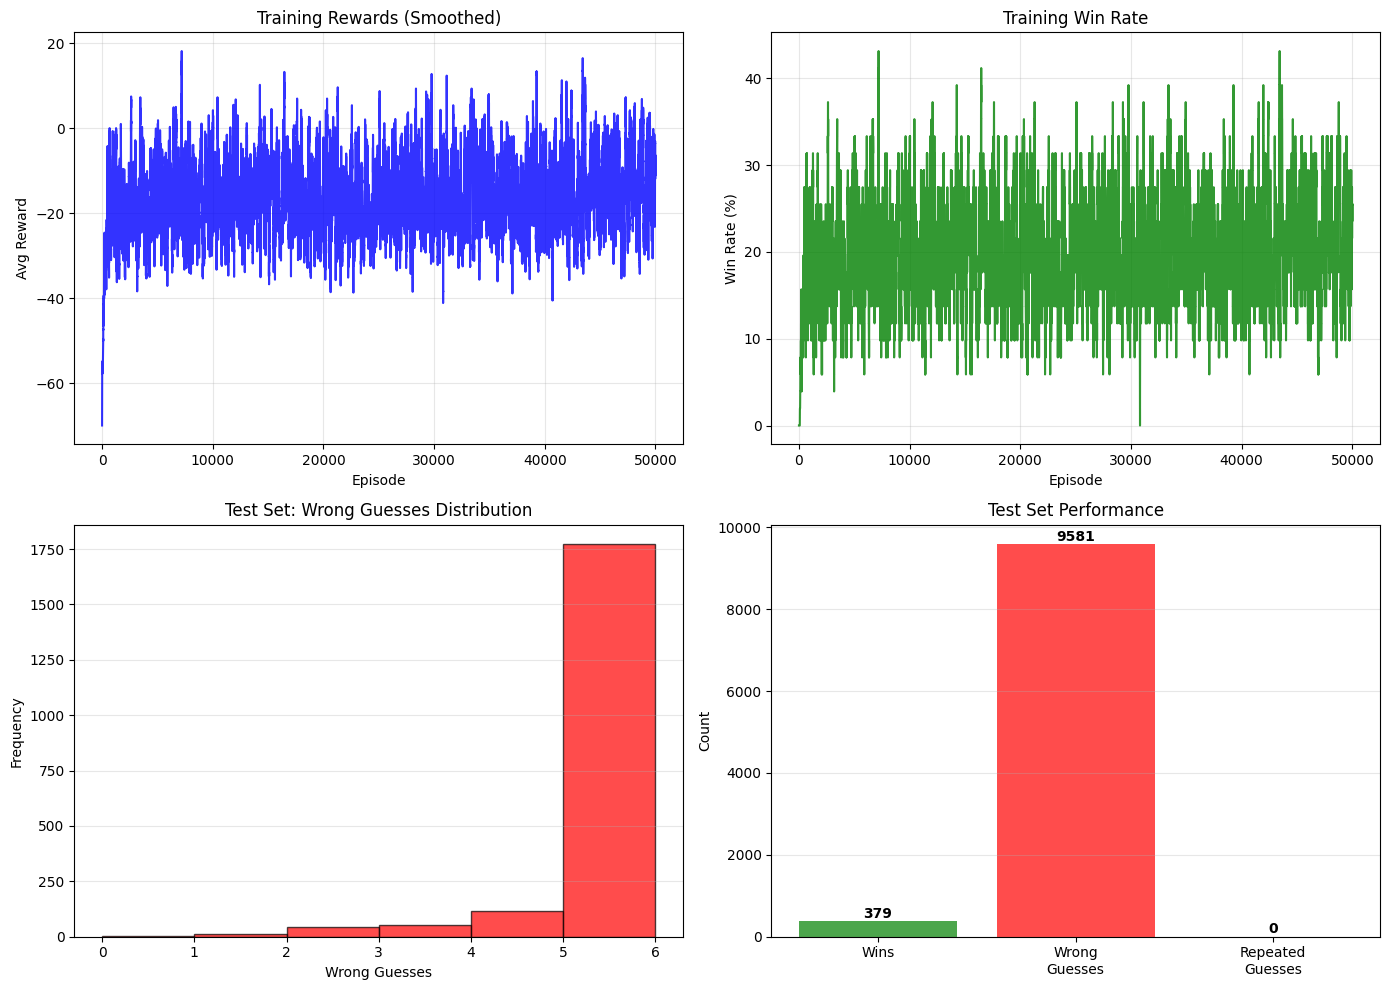

✅ Visualization saved as 'hmm_qlearning_results.png'


In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Rewards
window = 50
smoothed = [np.mean(training_rewards[max(0,i-window):i+1]) for i in range(len(training_rewards))]
axes[0,0].plot(smoothed, color='blue', alpha=0.8)
axes[0,0].set_xlabel('Episode')
axes[0,0].set_ylabel('Avg Reward')
axes[0,0].set_title('Training Rewards (Smoothed)')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Win Rate
smoothed_wins = [np.mean(training_wins[max(0,i-window):i+1])*100 for i in range(len(training_wins))]
axes[0,1].plot(smoothed_wins, color='green', alpha=0.8)
axes[0,1].set_xlabel('Episode')
axes[0,1].set_ylabel('Win Rate (%)')
axes[0,1].set_title('Training Win Rate')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Wrong Guesses Distribution
wrongs = [s['wrong_guesses'] for s in test_results['details']]
axes[1,0].hist(wrongs, bins=range(0, max(wrongs)+2), edgecolor='black', alpha=0.7, color='red')
axes[1,0].set_xlabel('Wrong Guesses')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Test Set: Wrong Guesses Distribution')
axes[1,0].grid(True, alpha=0.3, axis='y')

# Plot 4: Performance Summary
metrics = ['Wins', 'Wrong\nGuesses', 'Repeated\nGuesses']
values = [test_results['wins'], test_results['wrong_guesses'], test_results['repeated_guesses']]
colors = ['green', 'red', 'orange']
bars = axes[1,1].bar(metrics, values, color=colors, alpha=0.7)
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Test Set Performance')
axes[1,1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, val + 10, str(val),
                  ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('hmm_qlearning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'hmm_qlearning_results.png'")

## Section 13: Save Models

In [13]:
# Save models
with open('hmm_model.pkl', 'wb') as f:
    pickle.dump(hmm, f)

with open('qlearning_agent.pkl', 'wb') as f:
    pickle.dump(agent, f)

with open('test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

print("✅ Models saved:")
print("   - hmm_model.pkl")
print("   - qlearning_agent.pkl")
print("   - test_results.pkl")

✅ Models saved:
   - hmm_model.pkl
   - qlearning_agent.pkl
   - test_results.pkl


##  Implementation Summary

### Components Implemented

#### 1. Complete Hidden Markov Model
-  Forward Algorithm (α) for likelihood computation
-  Backward Algorithm (β) for posterior probabilities
-  Viterbi Algorithm (δ) for optimal state sequence
-  Emission Matrix (B) with Laplace smoothing
-  Transition Matrix (A) for letter bigrams
-  Separate models for each word length (1-30)

#### 2. Q-Learning Agent
-  Tabular Q-Learning with sparse state representation
-  Epsilon-greedy exploration with decay
-  Hybrid action selection (60% Q-values + 40% HMM)
-  State representation: (masked_word, guessed_letters, lives)



